In [ ]:
# need to install ta-lib and yfinance
# https://blog.quantinsti.com/install-ta-lib-python/

## Classifying stock returns using statistical features and random forest

Goal: To predict if the stock will have positive or negative retuns tomorrow by building statistical features from daily OHLCV data.

### Steps
1. Load OHLCV data from yahoo finance for given stocks
2. Generate statistical features form the daily data using Python's talib library
    - Simple Moving Average
    - Exponential Moving Average
    - Relative Strength Index
    - of periods `[2, 5, 15]`
3. Generate targets based on daily returns
    - `data["adj_close"].pct_change(1)`
    - this will tell how much each stock moved next day
    - We simply convert this to buinary targets based on `1_day_returns >=0 `.
    - This gives us if the stock moved positive or negatively on next day
    - Now we have features + targets. Let's train a Random Forest model
4. Modelling
    - Random forest
    - K-fold Cross-validation won't work
    - Embargo
    - Moving window CV

In [1]:
import yfinance
import gc

import talib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm.auto import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, balanced_accuracy_score, precision_recall_fscore_support, \
    f1_score, accuracy_score, roc_auc_score
from datetime import timedelta


The financial data we'll use here is based on Yahoo data store. We'll fetch Open, High, Low, Close adn Volume for selected stocks from Yahoo and concatenate them in one single dataframe. see the output in cell below for results.

In [2]:
tickers = [
    "AAPL",
    "TSLA",
    "MSFT",
    "SPY",
    "GOOG",
]

tmp_arr = []
for ticker in tickers:
    tmp = yfinance.download(ticker, threads=False)
    tmp.rename(columns={
        "Open":"open",
        "High":"high",
        "Low":"low",
        "Close":"close",
        "Adj Close":"adj_close",
    }, inplace=True)

    tmp["ticker"] = ticker
    tmp = tmp.iloc[10:, :]

    data = tmp
    data = data.sort_index()
    tmp_arr.append(data)

data = pd.concat(tmp_arr)

data.tail(100)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,open,high,low,close,adj_close,Volume,ticker
Date,,,,,,,
2022-01-20,2730.280029,2758.239990,2662.889893,2670.129883,2670.129883,1096500,GOOG
2022-01-21,2660.239990,2695.209961,2600.020020,2601.840088,2601.840088,2096000,GOOG
2022-01-24,2520.550049,2615.570068,2492.839111,2607.439941,2607.439941,2757400,GOOG
2022-01-25,2568.709961,2586.770020,2527.560059,2534.709961,2534.709961,1800400,GOOG
2022-01-26,2611.850098,2656.149902,2543.070068,2584.800049,2584.800049,1981500,GOOG
...,...,...,...,...,...,...,...
2022-06-07,2312.959961,2354.972900,2302.510010,2344.590088,2344.590088,1320700,GOOG
2022-06-08,2337.530029,2372.919922,2333.935059,2344.760010,2344.760010,1127200,GOOG
2022-06-09,2326.830078,2367.000000,2297.340088,2298.360107,2298.360107,1157100,GOOG


Now we have OHLCV data. 
Let's generate the target. 

It is how much the stock moved on next day.

Check output of next cell for results

In [3]:
# 1 day means => % returns on next day
data["target_1d"] = data["adj_close"].pct_change(1)
data.dropna(axis=0, inplace=True)

# removing outliers having huge changes probably due to error in data
data = data[data["target_1d"]>-0.5].copy()
gc.collect()

# generating custom binary targets based on returns of 1 day
data["bin_tgt_1d"] = (data["target_1d"] > 0).astype(int)

In [4]:
data

,open,high,low,close,adj_close,Volume,ticker,target_1d,bin_tgt_1d
Date,,,,,,,,,
1980-12-30,0.157366,0.157366,0.156808,0.156808,0.122392,68880000,AAPL,-0.024304,0
1980-12-31,0.152902,0.152902,0.152344,0.152344,0.118908,35750400,AAPL,-0.028468,0
1981-01-02,0.154018,0.155134,0.154018,0.154018,0.120214,21660800,AAPL,0.010988,1
1981-01-05,0.151228,0.151228,0.150670,0.150670,0.117601,35728000,AAPL,-0.021737,0
1981-01-06,0.144531,0.144531,0.143973,0.143973,0.112374,45158400,AAPL,-0.044448,0
...,...,...,...,...,...,...,...,...,...
2022-06-07,2312.959961,2354.972900,2302.510010,2344.590088,2344.590088,1320700,GOOG,0.001872,1
2022-06-08,2337.530029,2372.919922,2333.935059,2344.760010,2344.760010,1127200,GOOG,0.000072,1
2022-06-09,2326.830078,2367.000000,2297.340088,2298.360107,2298.360107,1157100,GOOG,-0.019789,0


<AxesSubplot:>

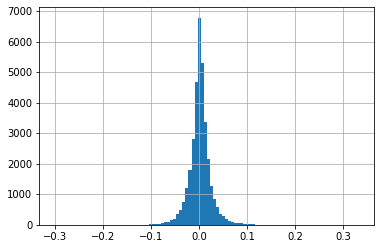

In [5]:
# interesting! innit? The returns resembles a gaussian?
data["target_1d"].hist(bins=100)

<AxesSubplot:xlabel='Date'>

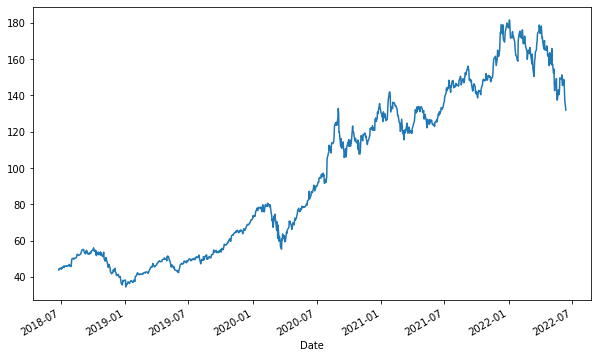

In [6]:
# Just a simple plot of close prices of AAPL stock in last 1000 days
data[data["ticker"]=="AAPL"]["adj_close"].iloc[-1000:].plot(figsize=(10, 6))

<AxesSubplot:xlabel='Date'>

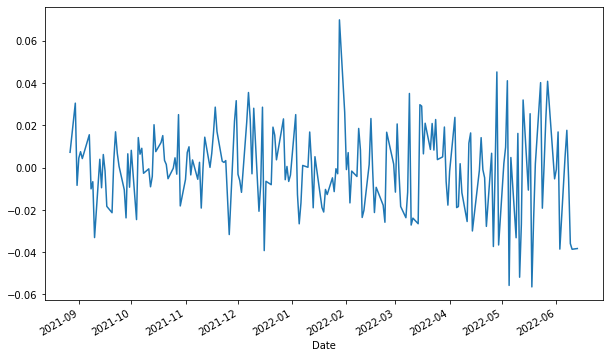

In [7]:
# returns in last 200 days for AAPL
data[data["ticker"]=="AAPL"]["target_1d"].iloc[-200:].plot(figsize=(10, 6))

Now we need to generate features. Think of this a sturning a timeseries into a tabular problem.

These are all **statististical** features generated using Python's talib library.

You can read more on them in links below

- rsi : https://www.investopedia.com/terms/r/rsi.asp
- sma, ema: https://www.investopedia.com/terms/m/movingaverage.asp




Check output in next cell for results

In [8]:
def sma(hist, timeperiod=14):
    res = talib.SMA(hist, timeperiod=timeperiod)
    return pd.Series(res, name=f"feature_sma_{timeperiod}")

def rsi(hist, timeperiod=14):
    res = talib.RSI(hist, timeperiod=timeperiod)
    return pd.Series(res ,name=f"feature_rsi_{timeperiod}")

def ema(hist, timeperiod=14):
    res = talib.EMA(hist, timeperiod=timeperiod)
    return pd.Series(res, name=f"feature_ema_{timeperiod}")

def generate_features(df):

    close = df["adj_close"]
    features = []

    for period in [2, 5, 15]:
        features.append(sma(close, timeperiod=period))

    for period in [2, 5, 15]:
        features.append(ema(close, timeperiod=period))

    for period in [2, 5, 15]:
        features.append(rsi(close, timeperiod=period))

    return pd.concat(features, 1)

In [9]:
features = generate_features(data)
full_data = pd.concat([data, features], 1)

feature_cols = [f for f in features.columns]

full_data.replace([np.inf, -np.inf], np.nan, inplace=True)
full_data = full_data.dropna(subset=feature_cols, axis=0)

C:\Users\surajp\AppData\Local\Temp\ipykernel_11608\3526440444.py:27: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(features, 1)
C:\Users\surajp\AppData\Local\Temp\ipykernel_11608\3828379683.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  full_data = pd.concat([data, features], 1)


In [10]:
# columns starting with "feature_" are the features and "bin_tgt_" is the binary target
full_data

,open,high,low,close,adj_close,Volume,ticker,target_1d,bin_tgt_1d,feature_sma_2,feature_sma_5,feature_sma_15,feature_ema_2,feature_ema_5,feature_ema_15,feature_rsi_2,feature_rsi_5,feature_rsi_15
Date,,,,,,,,,,,,,,,,,,
1981-01-21,0.145089,0.146205,0.145089,0.145089,0.113245,15904000,AAPL,0.019606,1,0.112156,0.111155,0.111474,0.112667,0.111531,0.112229,67.340823,56.746985,39.999264
1981-01-22,0.146763,0.147879,0.146763,0.146763,0.114552,35548800,AAPL,0.011538,1,0.113898,0.112287,0.111184,0.113924,0.112538,0.112519,77.349132,61.007066,41.781518
1981-01-23,0.146763,0.147321,0.146205,0.146205,0.114116,11222400,AAPL,-0.003802,0,0.114334,0.113507,0.110777,0.114052,0.113064,0.112719,64.226821,58.601971,41.342901
1981-01-26,0.144531,0.144531,0.143973,0.143973,0.112374,24640000,AAPL,-0.015266,0,0.113245,0.113071,0.110429,0.112933,0.112834,0.112676,27.249191,48.953724,39.563162
1981-01-27,0.143973,0.143973,0.142857,0.142857,0.111503,23699200,AAPL,-0.007751,0,0.111939,0.113158,0.110371,0.111980,0.112390,0.112529,17.292950,44.386324,38.671333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-07,2312.959961,2354.972900,2302.510010,2344.590088,2344.590088,1320700,GOOG,0.001872,1,2342.400024,2322.747998,2251.218669,2339.070413,2316.998703,2286.101641,71.513290,65.554559,51.578157
2022-06-08,2337.530029,2372.919922,2333.935059,2344.760010,2344.760010,1127200,GOOG,0.000072,1,2344.675049,2335.152002,2251.934001,2342.863478,2326.252472,2293.433937,71.682775,65.590446,51.590589
2022-06-09,2326.830078,2367.000000,2297.340088,2298.360107,2298.360107,1157100,GOOG,-0.019789,0,2321.560059,2323.840039,2255.290007,2313.194564,2316.955017,2294.049709,16.869384,48.384357,47.986135


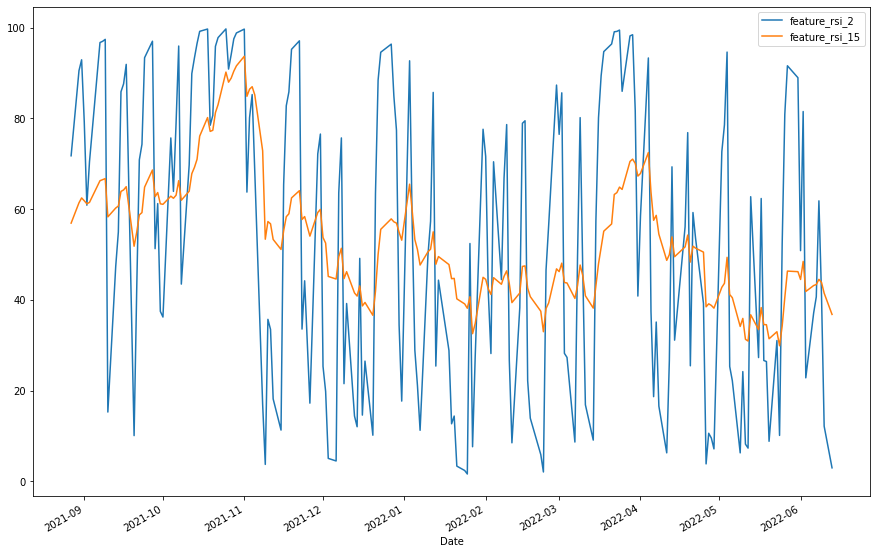

In [11]:
full_data[full_data["ticker"]=="TSLA"][["feature_rsi_2", "feature_rsi_15",]].iloc[-200:, :].plot(figsize=(15,10))
#plt.vlines(full_data.index[-100], ymin=00.25, ymax=0.75, color = 'r', label="embargo", linestyles="dashed")
#plt.text(full_data.index[-100], 0.5, "embargo", rotation=90, verticalalignment="center")
plt.show()

<AxesSubplot:xlabel='Date'>

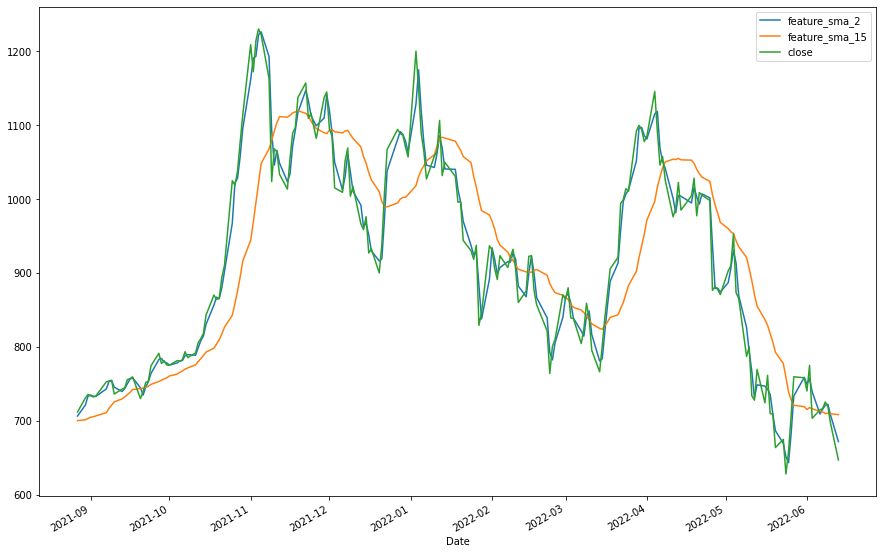

In [12]:
full_data[full_data["ticker"]=="TSLA"][["feature_sma_2", "feature_sma_15", "close"]].iloc[-200:, :].plot(figsize=(15,10))

<AxesSubplot:xlabel='Date'>

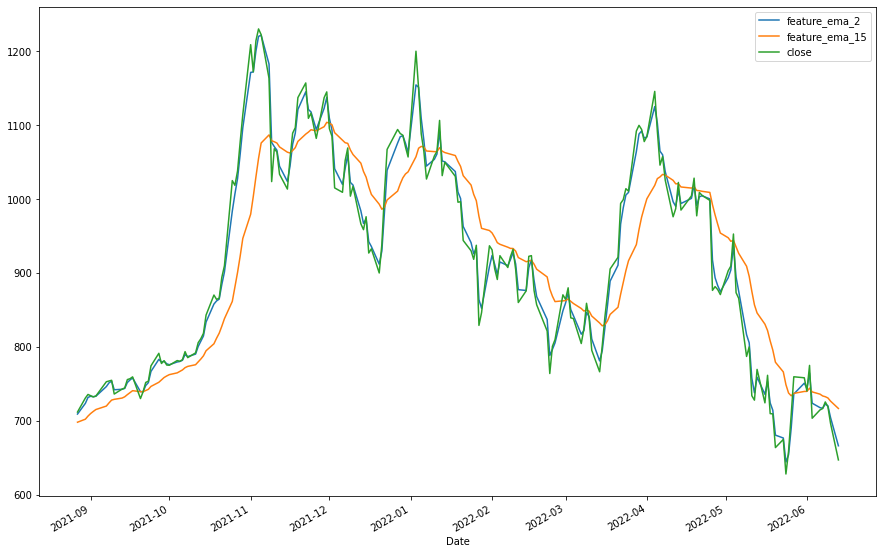

In [13]:
full_data[full_data["ticker"]=="TSLA"][["feature_ema_2", "feature_ema_15", "close"]].iloc[-200:, :].plot(figsize=(15,10))

In [14]:
feature_names = [c for c in full_data.columns if "feature" in c]
target_name = "bin_tgt_1d"

Since classical K-fold CV won't work here because of data leakage, We will use sliding window cross-validation.

embargo refers to the gap between training and evaluation samples. Here we're having `embargo_days=90` days. So, this period will be excluded from training and evaluation splits just to prevent any leakage of data

In [15]:
# splitting with embargo based on AFML by Lopez De Prado

thresh = "2015-01-01"
embargo_days = 90 #days

train_samples = full_data[full_data.index<thresh]
eval_samples = full_data[full_data.index>(
    train_samples.index.sort_values()[-1]+timedelta(days=embargo_days)
    )]

total_samples = train_samples.shape[0] + eval_samples.shape[0]

print("Excluding Embargo samples\ntraining data %:",
    len(train_samples)/total_samples, "\nValidation sample %:",len(eval_samples)/total_samples
    )

Excluding Embargo samples
training data %: 0.7341735052754983 
Validation sample %: 0.26582649472450176


<AxesSubplot:>

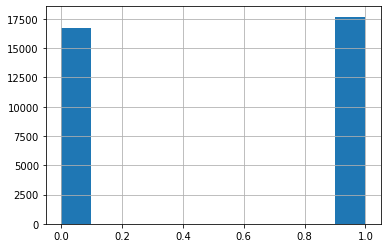

In [16]:
full_data["bin_tgt_1d"].hist()

In [18]:
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    )

clf.fit(
    train_samples[feature_names], train_samples[target_name],
)

valid_preds = clf.predict(eval_samples[feature_names])
train_preds = clf.predict(train_samples[feature_names])

valid_preds_proba = clf.predict_proba(eval_samples[feature_names])[:, 1]
train_preds_proba = clf.predict_proba(train_samples[feature_names])[:, 1]

metrics = {}

metrics["train_accuracy"] = accuracy_score(train_samples[target_name], train_preds)
metrics["eval_accuracy"] = accuracy_score(eval_samples[target_name], valid_preds)
metrics["train_f1"] = f1_score(train_samples[target_name], train_preds)
metrics["eval_f1"] = f1_score(eval_samples[target_name], valid_preds)
metrics["train_roc_auc"] = roc_auc_score(train_samples[target_name], train_preds)
metrics["eval_roc_auc"] = roc_auc_score(eval_samples[target_name], valid_preds)

print(metrics)

{'train_accuracy': 0.8598003992015968, 'eval_accuracy': 0.8424476295479603, 'train_f1': 0.8647982753310749, 'eval_f1': 0.8566268686665998, 'train_roc_auc': 0.8594809634809636, 'eval_roc_auc': 0.8396632452828419}
